## README file for ``nu_nu_collisions.py`` 

This code models neutrino-neutrino collisions in the early universe. It is run in ``basic_code.py`` (see https://github.com/hannahrasmussen/BasicCode). To make a ``nu_nu_coll`` package, execute the following steps:

1. Navigate to the directory that your BasicCode folder is in. Make a folder there called ``nu_nu_coll``, then make a folder within ``nu_nu_coll`` that is also named ``nu_nu_coll``.
2. Download ``nu_nu_collisions.py`` from my GitHub page at https://github.com/hannahrasmussen/nu_nu_coll (you've probably already done that if you're reading this) and put it in the folder within the folder.
3. In the folder (not the folder within the folder), put a ``setup.py`` folder with the following code:
        from setuptools import setup
        setup(name='nu_nu_coll',
          version='0.1',
          description='Neutrino-neutrino collision code',
          url='https://github.com/hannahrasmussen/nu_nu_coll',
          author='Hannah Rasmussen',
          author_email='hannahrasmussen17@gmail.com',
          license='MIT',
          packages=['nu_nu_coll'],
          zip_safe=False)
          
4. Now, go to the terminal and checkout your new folder (not the folder within a folder) using the ‘cd’ command. 
5. Once you’re there, type and enter ‘pip install -e .’ (including the period). That ‘-e’ extension means that updates you make to the code are automatically also installed, which is obviously what we want.
6. Now, to see if it worked, open a separate jupyter notebook kernel and try and do ‘from nu_nu_coll import nu_nu_collisions’. If there are no errors, you can delete that line and should be good to run the code as is.

## Imports

* installs ``numpy``, a python package that allows for quick and easy computing using multi-dimensional arrays
* from ``numba``, a python package designed to interface with ``numpy`` and make the code run significantly faster (at least one order of magnitude), ``jit`` and ``prange`` are imported. The wrapper ``@jit`` simply marks a function for ``numba`` to compile. ``prange`` denotes a for loop that can be done in parallel, so speedy! 

The ultimate goal of this code is to compute the integral 

$$ \begin{aligned} I = \frac{G_F^2}{(2\pi^3)p_1^2} \Bigg\{  & \int_0^{p_1} dp_2 \left[ \int_0^{p_2} dp_3 FJ_1(p_1,p_2,p_3) + \int_{p_2}^{p_1} dp_3 FJ_2(p_1,p_2) + \int_{p_1}^{p_1+p_2} dp_3 FJ_3(p_1,p_2,p_3) \right] \Bigg. \\ \Bigg. &+ \int_{p_1}^{\infty} dp_2 \left[ \int_0^{p_1}dp_3 FJ_1 (p_1,p_2,p_3) + \int_{p_1}^{p_2} dp_3 FJ_2(p_2,p_1) + \int_{p_2}^{p_1+p_2} dp_3 FJ_3 (p_1,p_2,p_3) \right] \Bigg\} \end{aligned} $$

where $J_1$, $J_2$, and $J_3$ are described in the next window. $F = F_p = (1-f(p_1))(1-f(p_2))f(p_3)f(p_4)$ and $F = F_m = f(p_1)f(p_2)(1-f(p_3))(1-f(p_4))$.

## J functions

### ``J1``
* **Imports**
    * ``p1``: $p_1$ Momentum of $\nu_1$
    * ``p2``: $p_2$ Momentum of $\nu_2$
    * ``p3``: $p_3$ Momentum of $\nu_3$
* **Outputs**
    * The integrand $J_1$: $$ J_1(p_1,p_2,p_3) = \int_{p_1+p_2 - 2p_3}^{p_1+p_2} dy [(p_1+p_2)^2-y^2]^2 = \frac{16}{15} p_3^3 \left( 10(p_1+p_2)^2 - 15 p_3 (p_1+p_2)+6p_3^2 \right) $$
    
### ``J2``
* **Imports**
    * ``p1``: $p_1$ Momentum of $\nu_1$
    * ``p2``: $p_2$ Momentum of $\nu_2$
* **Outputs**
    * The integrand $J_2$: $$ J_2(p_1,p_2) = \int_{p_1-p_2}^{p_1+p_2} dy [(p_1+p_2)^2-y^2]^2 = \frac{16}{15} p_2^3 \left( 10p_1^2 + 5p_1p_2 + p_2^2 \right) $$
    
### ``J3``
* **Imports**
    * ``p1``: $p_1$ Momentum of $\nu_1$
    * ``p2``: $p_2$ Momentum of $\nu_2$
    * ``p3``: $p_3$ Momentum of $\nu_3$
* **Outputs**
    * The integrand $J_3$: $$ J_3(p_1,p_2,p_3) = \int_{2p_3-p_1-p_2}^{p_1+p_2} dy [(p_1+p_2)^2-y^2]^2  = \frac{16}{15} \left( (p_1+p_2)^5 - 10p_3^3(p_1+p_2)^2 + 15p_3^4(p_1+p_2) - 6p_3^5 \right) $$

## A and B functions

### ``B1`` 
Integrates over $p_3$ (the value of $p_4$ is explicitly defined at this point) from 0 to $p_2$.
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``, $p_1 =$ ``p[i]``
    * ``j``: Current index of ``p`` being evaluated in ``A1``, $p_2 =$ ``p[j]``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``u``: If ``i + j >= len(f)-1``, ``u = len(f)-1``, the final index value of ``f``. Otherwise, ``u=i+j``
    * ``h``: If ``i + j >= len(f)-1``, ``h = i+j-u``. Otherwise ``h=0``.
    * ``k``: Array of possible indices such that ``p[k]`` $= p_3$, which goes from ``p[h]`` to ``p[j]``. Generally ``h`` = 0, unless $p_1+p_2>$ ``p[-1]``, in which case we discount the possibility of $p_3$ being 0 because then $p_4$ would be out of bounds of the array ``p``.
    * ``w``: Simply a counting variable in the first for loop.
    * ``FpJ1i``: The integrand at $p_3 =$ ``f[h]`` with $F=F_p$
    * ``FpJ1f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_p$
    * ``FmJ1i``: The integrand at $p_3 =$ ``f[h]`` with $F=F_m$
    * ``FmJ1f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_m$
* **Outputs**:
    * ``BP``: The addition in occupation fraction to the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FpJ1``.
    * ``BN``: The subtraction in occupation fraction from the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FmJ1``.
    
### ``A1`` 
Integrates over $p_2$
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``BP``: An array of length ``i+1``, since the limits of the ``A1`` integral are 0 to $p_1 =$ ``p[i]``, whose individual indices are evaluations of ``B1`` at $p_2 =$ ``p[j]`` using $F=F_p$.
    * ``BN``: An array of length ``i+1``, since the limits of the ``A1`` integral are 0 to $p_1 =$ ``p[i]``, whose individual indices are evaluations of ``B1`` at $p_2 =$ ``p[j]`` using $F=F_m$.
* **Outputs**:
    * ``AP``: The total addition in occupation fraction to the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BP``.
    * ``AN``: The total subtraction in occupation fraction from the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BN``.
    
### ``B2`` 
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``j``: Current index of ``p`` being evaluated in ``A2``, $p_2 =$ ``p[j]``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``m``:
    * ``n``:
    * ``o``:
    * ``u``: If ``i + j >= len(f)-1``, ``u = len(f)-1``, the final index value of ``f``. Otherwise, ``u=i+j``
    * ``h``: If ``i + j >= len(f)-1``, ``h = i+j-u``. Otherwise ``h=0``.
    * ``k``: Array of possible indices such that ``p[k]`` $= p_3$, which goes from ``p[m]`` to ``p[n]``. Generally ``h`` = 0, unless $p_2<p_1$, in which case we discount the possibility of $p_3$ being 0 because then $p_4$ would be out of bounds of the array ``p``.
    * ``w``: Simply a counting variable in the first for loop.
    * ``FpJ2i``: The integrand at $p_3 =$ ``f[i]`` with $F=F_p$
    * ``FpJ2f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_p$
    * ``FmJ2i``: The integrand at $p_3 =$ ``f[i]`` with $F=F_m$
    * ``FmJ2f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_m$
* **Outputs**:
    * ``BP``: The addition in occupation fraction to the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FpJ2``.
    * ``BN``: The subtraction in occupation fraction from the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FmJ2``.
    
### ``A2`` 
Integrates over $p_2$
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``BP``: An array of length ``i+1``, since the limits of the ``A2`` integral are 0 to $p_1 =$ ``p[i]``, whose individual indices are evaluations of ``B2`` at $p_2 =$ ``p[j]`` using $F=F_p$.
    * ``BN``: An array of length ``i+1``, since the limits of the ``A2`` integral are 0 to $p_1 =$ ``p[i]``, whose individual indices are evaluations of ``B2`` at $p_2 =$ ``p[j]`` using $F=F_m$.
* **Outputs**:
    * ``AP``: The total addition in occupation fraction to the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BP``.
    * ``AN``: The total subtraction in occupation fraction from the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BN``.
    
### ``B3`` 
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``j``: Current index of ``p`` being evaluated in ``A2``, $p_2 =$ ``p[j]``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``u``: If ``i + j >= len(f)-1``, ``u = len(f)-1``, the final index value of ``f``. Otherwise, ``u=i+j``
    * ``h``: If ``i + j >= len(f)-1``, ``h = i+j-u``. Otherwise ``h=0``.
    * ``k``: Array of possible indices such that ``p[k]`` $= p_3$, which goes from ``p[i]`` to ``p[u]``. Generally ``u`` = ``len(f)-1``, unless $p_1+p_2>$ ``p[-1]``, in which case we discount the possibility of $p_3$ being greater than ``p[len(f)-1]`` because then $p_3$ would be out of bounds of the array ``p``.
    * ``w``: Simply a counting variable in the first for loop.
    * ``FpJ1i``: The integrand at $p_3 =$ ``f[h]`` with $F=F_p$
    * ``FpJ1f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_p$
    * ``FmJ1i``: The integrand at $p_3 =$ ``f[h]`` with $F=F_m$
    * ``FmJ1f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_m$
* **Outputs**:
    * ``BP``: The addition in occupation fraction to the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FpJ3``.
    * ``BN``: The subtraction in occupation fraction from the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FmJ3``.
    
### ``A3`` 
Integrates over $p_2$
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``BP``: An array of length ``i+1``, since the limits of the ``A3`` integral are 0 to $p_1 =$ ``p[i]``, whose individual indices are evaluations of ``B3`` at $p_2 =$ ``p[j]`` using $F=F_p$.
    * ``BN``: An array of length ``i+1``, since the limits of the ``A3`` integral are 0 to $p_1 =$ ``p[i]``, whose individual indices are evaluations of ``B3`` at $p_2 =$ ``p[j]`` using $F=F_m$.
* **Outputs**:
    * ``AP``: The total addition in occupation fraction to the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BP``.
    * ``AN``: The total subtraction in occupation fraction from the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BN``.
    
### ``B4`` 
Integrates over $p_3$ (the value of $p_4$ is explicitly defined at this point) from 0 to $p_1$.
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``, $p_1 =$ ``p[i]``
    * ``j``: Current index of ``p`` being evaluated in ``A4``, $p_2 =$ ``p[j]``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``u``: If ``i + j >= len(f)-1``, ``u = len(f)-1``, the final index value of ``f``. Otherwise, ``u=i+j``
    * ``h``: If ``i + j >= len(f)-1``, ``h = i+j-u``. Otherwise ``h=0``.
    * ``k``: Array of possible indices such that ``p[k]`` $= p_3$, which goes from ``p[h]`` to ``p[j]``. Generally ``h`` = 0, unless $p_1+p_2>$ ``p[-1]``, in which case we discount the possibility of $p_3$ being 0 because then $p_4$ would be out of bounds of the array ``p``.
    * ``w``: Simply a counting variable in the first for loop.
    * ``FpJ1i``: The integrand at $p_3 =$ ``f[h]`` with $F=F_p$
    * ``FpJ1f``: The integrand at $p_3 =$ ``f[i]`` with $F=F_p$
    * ``FmJ1i``: The integrand at $p_3 =$ ``f[h]`` with $F=F_m$
    * ``FmJ1f``: The integrand at $p_3 =$ ``f[i]`` with $F=F_m$
* **Outputs**:
    * ``BP``: The addition in occupation fraction to the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FpJ1``.
    * ``BN``: The subtraction in occupation fraction from the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FmJ1``.
    
### ``A4`` 
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``BP``: An array of length ``len(f)-1-i``, since the limits of the ``A4`` integral are $p_1 =$ ``p[i]`` to $\infty$, whose individual indices are evaluations of ``B4`` at $p_2 =$ ``p[j]`` using $F=F_p$.
    * ``BN``: An array of length ``len(f)-1-i``, since the limits of the ``A4`` integral are $p_1 =$ ``p[i]`` to $\infty$, whose individual indices are evaluations of ``B4`` at $p_2 =$ ``p[j]`` using $F=F_m$.
    * ``v``: Simply a counting variable in the for loop
* **Outputs**:
    * ``AP``: The total addition in occupation fraction to the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BP``.
    * ``AN``: The total subtraction in occupation fraction from the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BN``.
    
### ``B5`` 
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``j``: Current index of ``p`` being evaluated in ``A2``, $p_2 =$ ``p[j]``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``m``:
    * ``n``:
    * ``o``:
    * ``u``: If ``i + j >= len(f)-1``, ``u = len(f)-1``, the final index value of ``f``. Otherwise, ``u=i+j``
    * ``h``: If ``i + j >= len(f)-1``, ``h = i+j-u``. Otherwise ``h=0``.
    * ``k``: Array of possible indices such that ``p[k]`` $= p_3$, which goes from ``p[m]`` to ``p[n]``. Generally ``h`` = 0, unless $p_2<p_1$, in which case we discount the possibility of $p_3$ being 0 because then $p_4$ would be out of bounds of the array ``p``.
    * ``w``: Simply a counting variable in the first for loop.
    * ``FpJ2i``: The integrand at $p_3 =$ ``f[i]`` with $F=F_p$
    * ``FpJ2f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_p$
    * ``FmJ2i``: The integrand at $p_3 =$ ``f[i]`` with $F=F_m$
    * ``FmJ2f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_m$
* **Outputs**:
    * ``BP``: The addition in occupation fraction to the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FpJ2``.
    * ``BN``: The subtraction in occupation fraction from the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FmJ2``.
    
### ``A5`` 
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``BP``: An array of length ``len(f)-1-i``, since the limits of the ``A5`` integral are $p_1 =$ ``p[i]`` to $\infty$, whose individual indices are evaluations of ``B5`` at $p_2 =$ ``p[j]`` using $F=F_p$.
    * ``BN``: An array of length ``len(f)-1-i``, since the limits of the ``A5`` integral are $p_1 =$ ``p[i]`` to $\infty$, whose individual indices are evaluations of ``B5`` at $p_2 =$ ``p[j]`` using $F=F_m$.
    * ``v``: Simply a counting variable in the for loop
* **Outputs**:
    * ``AP``: The total addition in occupation fraction to the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BP``.
    * ``AN``: The total subtraction in occupation fraction from the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BN``.
    
### ``B6`` 
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``j``: Current index of ``p`` being evaluated in ``A2``, $p_2 =$ ``p[j]``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``u``: If ``i + j >= len(f)-1``, ``u = len(f)-1``, the final index value of ``f``. Otherwise, ``u=i+j``
    * ``h``: If ``i + j >= len(f)-1``, ``h = i+j-u``. Otherwise ``h=0``.
    * ``k``: Array of possible indices such that ``p[k]`` $= p_3$, which goes from ``p[j]`` to ``p[u]``. Generally ``u`` = ``len(f)-1``, unless $p_1+p_2>$ ``p[-1]``, in which case we discount the possibility of $p_3$ being greater than ``p[len(f)-1]`` because then $p_3$ would be out of bounds of the array ``p``.
    * ``w``: Simply a counting variable in the first for loop.
    * ``FpJ3i``: The integrand at $p_3 =$ ``f[h]`` with $F=F_p$
    * ``FpJ3f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_p$
    * ``FmJ3i``: The integrand at $p_3 =$ ``f[h]`` with $F=F_m$
    * ``FmJ3f``: The integrand at $p_3 =$ ``f[j]`` with $F=F_m$
* **Outputs**:
    * ``BP``: The addition in occupation fraction to the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FpJ3``.
    * ``BN``: The subtraction in occupation fraction from the current momentum box (``p[i]``) when $p_2 =$ ``p[j]`` from this term. Calculated by using the trapezoid rule to integrate over ``FmJ3``.
    
### ``A6`` 
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``f``: Occupation fraction of active neutrinos
    * ``p``: Array of neutrino momenta
    * ``dp``: Boxsize of ``p``
* **Calculations**
    * ``BP``: An array of length ``len(f)-1-i``, since the limits of the ``A6`` integral are $p_1 =$ ``p[i]`` to $\infty$, whose individual indices are evaluations of ``B6`` at $p_2 =$ ``p[j]`` using $F=F_p$.
    * ``BN``: An array of length ``len(f)-1-i``, since the limits of the ``A6`` integral are $p_1 =$ ``p[i]`` to $\infty$, whose individual indices are evaluations of ``B6`` at $p_2 =$ ``p[j]`` using $F=F_m$.
    * ``v``: Simply a counting variable in the for loop.
* **Outputs**:
    * ``AP``: The total addition in occupation fraction to the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BP``.
    * ``AN``: The total subtraction in occupation fraction from the current momentum box (``p[i]``) from this term. Calculated by using the trapezoid rule to integrate over ``BN``.

## C functions

### ``cI`` 
Calls all the A functions for the given index and returns the difference in neutrino distribution function for that momentum ($I$ using $F_p - F_m$) and also returns ``FRS`` to compare $I$ to
* **Imports**
    * ``i``: Current index of ``p`` being evaluated in ``C``
    * ``f``: occupation fraction of active neutrinos
    * ``p``: array of momenta
* **Outputs**:
    * ``c``: An array of the differences in occupation fraction, positive values signifies neutrinos are being added at a given momenta and negative values signifies neutrinos are being taken away from that momenta.
    * ``FRS``: Not sure what FRS stands for but this is the addition of Ap and Am instead of the difference taken in ``c``, used to compare and eliminate any computational error
    
### ``C`` 
This function is called from ``BasicCode`` (I think) and is essentially the driver for calculating the change in neutrino distribution function due to neutrino-neutrino collisions. It runs through all the indices of ``p``.
* **Imports**
    * ``p``: array of momenta
    * ``f``: occupation fraction of active neutrinos
* **Outputs**:
    * ``c``: An array of the differences in occupation fraction, positive values signifies neutrinos are being added at a given momenta and negative values signifies neutrinos are being taken away from that momenta.
    
### ``C_nopar`` 
Same as ``C``, but just doesn't have the numba boolean ``parallel`` set to ``True`` like the function ``C`` does.
* **Imports**
    * ``p``: array of momenta
    * ``f``: occupation fraction of active neutrinos
* **Outputs**:
    * ``c``: An array of the differences in occupation fraction, positive values signifies neutrinos are being added at a given momenta and negative values signifies neutrinos are being taken away from that momenta.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nu_nu_collisions as nu_nu_new
import nu_nu_coll_old as nu_nu_old
rg = np.random.default_rng(seed=2054)

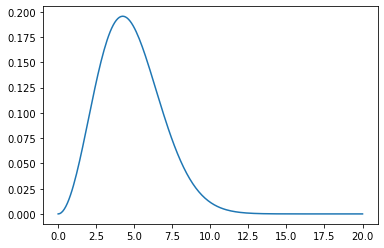

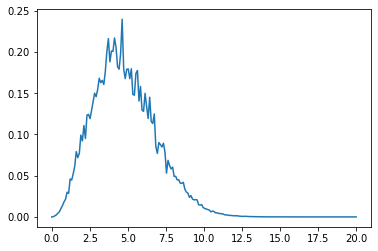

In [2]:
p = np.linspace(0,20,200)
a = 3
f = np.sqrt(2/np.pi)*p**2*(np.e**((-p**2)/(2*a**2))/a**3) #thermal distribution

plt.figure()
plt.plot(p,f)
plt.show()

rand_arr = rg.standard_normal(len(p))
f = (f*rand_arr/10)+f

plt.figure()
plt.plot(p,f)
plt.show()

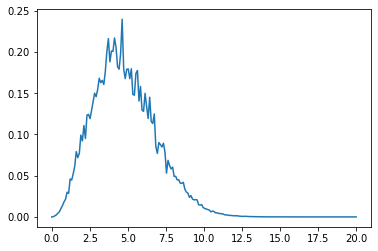

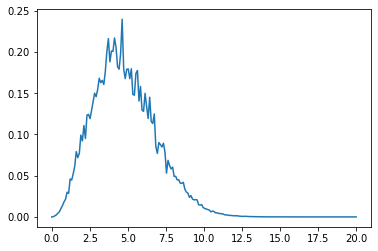

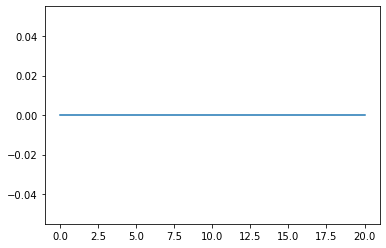

In [3]:
c_new = nu_nu_new.C(p,f)

plt.figure()
plt.plot(p,f+c_new)
plt.show()

c_old = nu_nu_old.C(p,f)

plt.figure()
plt.plot(p,f+c_old)
plt.show()

plt.figure()
plt.plot(p,abs(c_new-c_old))
plt.show()